In [ ]:
# !pip install pyepo
# !pip install gurobipy
# !pip install scipy

In [1]:
import sys
print(sys.version)

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import time
import json
from datetime import datetime
import ast

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from pyepo.data.dataset import optDataset
import pyepo
from pyepo.func import (
    blackboxOpt,
    negativeIdentity,
)
from matplotlib import pyplot as plt
import gurobipy as gp
from gurobipy import GRB
from pyepo.model.grb import optGrbModel
import pandas as pd
from tabulate import tabulate
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def visLearningCurve(loss_log, loss_log_regret, method='spo',n_aircraft = 30):
    # create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

    # draw plot for training loss
    ax1.plot(loss_log, color="c", lw=2)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)

    # draw plot for regret on test
    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=2)

    # Dynamically set x-ticks based on the number of epochs
    num_epochs = len(loss_log_regret)
    tick_spacing = max(1, num_epochs // 10)  # Ensure at least 1 tick, but aim for about 10 ticks
    ax2.set_xticks(range(0, num_epochs, tick_spacing))

    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, 0.5)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)
    plt.savefig(f'{method}_{n_aircraft}.png', dpi=300)
    plt.show()

In [ ]:
def WVseparation(A1, A2): #Encodes the separation time between aircraft types (J, H, M, L)
 #returns required separation time in seconds based on wake categories
        #Unit: seconds
        if A1 == 'J' and A2 == 'H':
            return 120
        elif A1 == 'J' and A2 == 'M':
            return 180
        elif A1 == 'J' and A2 == 'L':
            return 240
        elif A1 == 'H' and A2 == 'H':
            return 120
        elif A1 == 'H' and A2 == 'M':
            return 120
        elif A1 == 'H' and A2 == 'L':
            return 180
        elif A1 == 'M' and A2 == 'L':
            return 180
        else:
            return 120

class ASPmodel(optGrbModel):

    def __init__(self, n_aircraft, E, L, size, T):
        # Inputs:
        # n_aircraft: number of planes.
        # E: earliest landing times.
        # L: latest landing times.
        # size: wake turbulence category per aircraft.
        # T: target times.

        self.n_aircraft = n_aircraft
        self.aircraft = list(range(n_aircraft))

        self.E = E
        self.L = L
        self.size = size
        self.T = T
        self.S = {(i,j): WVseparation(self.size[i], self.size[j])
                  for i in self.aircraft for j in self.aircraft if i != j} #Builds separation times S[i,j] for all pairs.
        self.cost_vector = None
        super().__init__()
    @property
    def num_cost(self):
        return len(self.aircraft)
    def copy(self):
        """
        A method to copy model

        Returns:
            optModel: new copied model
        """
        new_model = type(self)(self.n_aircraft, self.E, self.L, self.size, self.T)
        return new_model

    def _getModel(self): #Building the MIP optimization model using Gurobi MIP
        m = gp.Model("ASP")
        # Decision variables
        self.x = m.addVars(self.n_aircraft, vtype=gp.GRB.BINARY, name="x")  # Binary variable for landing after target time
        self.delta = m.addVars(self.n_aircraft, self.n_aircraft, vtype=gp.GRB.BINARY, name="delta")  # Ordering variables
        self.y = m.addVars(self.n_aircraft, vtype=gp.GRB.CONTINUOUS, name="y")  # landing time

        # Builds the Gurobi MIP:
        # x[i]: binary: 1 if plane i lands after target time.
        # y[i]: continuous landing time.
        # delta[i,j]: ordering binary, either i before j or j before i.

        # sense
        m.modelSense = GRB.MINIMIZE

        # Constraints:
        # Enforce earliest / latest window.
        # Define x based on whether y[i] is before/after T[i] using big-M.
        # Enforce separation using S[i,j] and delta.

        m.addConstrs((self.y[i] >= self.E[i] for i in self.aircraft), "earliest_landing_time")
        m.addConstrs((self.y[i] <= self.L[i] for i in self.aircraft), "latest_landing_time")

        bigM = max(self.L.values()) + max(self.S.values())
        m.addConstrs((self.y[i] - self.T[i] <= bigM * self.x[i] for i in self.aircraft), "X_definition_1")
        m.addConstrs((self.y[i] - self.T[i] >= -bigM * (1 - self.x[i]) for i in self.aircraft), "X_definition_2")

        m.addConstrs((self.delta[i,j] + self.delta[j,i] == 1 for i in self.aircraft for j in self.aircraft if i != j), "delta_sum")

        m.addConstrs((self.y[j] - self.y[i] >= self.S[i,j] - bigM*self.delta[j,i] for i in self.aircraft for j in self.aircraft if i != j), "separation")

        # Return the model and the main decision variables
        return m, self.x

    def setObj(self, c): #Sets the objective: sum of penalties for planes landing late (x[i]=1), weighted by c[i]
        """
        A method to set objective function

        Args:
            c (float or list or np.ndarray): cost vector or single cost value
        """
        if isinstance(c, (float, int)):
            c = [c] * self.num_cost
        elif isinstance(c, list):
            c = np.array(c)

        if len(c) != self.num_cost:
            raise ValueError("Size of cost vector cannot match vars.")

        self.cost_vector = c
        obj = gp.quicksum(c[i] * self.x[i] for i in self.aircraft)
        self._model.setObjective(obj)

    def solve(self):
        """
        A method to solve model
        """
        self._model.update()
        self._model.optimize()

        if self._model.status == GRB.OPTIMAL:
            sol = np.array([self.x[i].x > 0.5 for i in self.aircraft], dtype=np.uint8)
            obj_val = self._model.objVal

            # Store additional solution information for post-analysis
            self._solution_data = {
                'landing_times': {i: self.y[i].x for i in self.aircraft},
                'landing_order': sorted(self.aircraft, key=lambda i: self.y[i].x)
            }

            return sol, obj_val
        else:
            raise ValueError(f"Optimization failed with status {self._model.status}")

    def post_analysis(self):
        """
        Perform post-analysis of the optimized solution and compare it with FCFS.

        Returns:
            dict: A dictionary containing analysis results and comparisons.
        """
        if self.cost_vector is None:
            raise ValueError("Cost vector not set. Please call setObj() before running post-analysis.")

        # Ensure the model has been solved
        if not hasattr(self, '_solution_data'):
            raise ValueError("Model has not been solved. Please call solve() before running post-analysis.")

        # Get optimized results
        opt_landing_times = self._solution_data['landing_times']
        opt_obj_val = self._model.objVal

        # Run FCFS simulation
        fcfs_landing_times, fcfs_total_cost = self.fcfs_simulation()

        # Prepare data for analysis
        data = []
        for i in self.aircraft:
            opt_landed_after = opt_landing_times[i] > self.T[i]
            fcfs_landed_after = fcfs_landing_times[i] > self.T[i]

            data.append({
                'Plane': i,
                'Opt Landing Time': f"{opt_landing_times[i]:.2f}",
                'FCFS Landing Time': f"{fcfs_landing_times[i]:.2f}",
                'Opt Landed After Target': 'Yes' if opt_landed_after else 'No',
                'FCFS Landed After Target': 'Yes' if fcfs_landed_after else 'No',
                'Time Window': f"[{self.E[i]}, {self.L[i]}]",
                'Target Time': self.T[i],
                'Cost': self.cost_vector[i] if opt_landed_after else 0
            })

        # Create DataFrame
        df = pd.DataFrame(data)

        # Calculate statistics
        opt_late_landings = sum(1 for i in self.aircraft if opt_landing_times[i] > self.T[i])
        fcfs_late_landings = sum(1 for i in self.aircraft if fcfs_landing_times[i] > self.T[i])

        # Prepare analysis results
        analysis = {
            'summary': tabulate(df, headers='keys', tablefmt='pretty'),
            'optimized_cost': opt_obj_val,
            'fcfs_cost': fcfs_total_cost,
            'opt_late_landings': opt_late_landings,
            'fcfs_late_landings': fcfs_late_landings
        }

        # Calculate cost improvement
        # Calculate cost improvement
        if fcfs_total_cost != 0 and opt_obj_val != 0:
            cost_diff = fcfs_total_cost - opt_obj_val
            cost_base = max(abs(fcfs_total_cost), abs(opt_obj_val))
            analysis['cost_improvement'] = f"{(cost_diff / cost_base) * 100:.2f}%"
        elif fcfs_total_cost == 0 and opt_obj_val == 0:
            analysis['cost_improvement'] = "0.00% (Both costs are 0)"
        else:
            analysis['cost_improvement'] = "100.00% (One cost is 0)"

        # Calculate late landings improvement
        late_landings_diff = fcfs_late_landings - opt_late_landings
        late_landings_base = max(fcfs_late_landings, opt_late_landings, 1)  # Avoid division by zero
        analysis['late_landings_improvement'] = f"{(late_landings_diff / late_landings_base) * 100:.2f}%"

        return analysis

    def fcfs_simulation(self):
        """
        Simulate First Come First Serve (FCFS) approach.

        Returns:
            tuple: FCFS landing times and total cost
        """
        if self.cost_vector is None:
            raise ValueError("Cost vector not set. Please call setObj() before running simulation.")

        sorted_planes = sorted(self.aircraft, key=lambda x: self.E[x])
        landing_times = {}
        total_cost = 0
        current_time = min(self.E.values())

        for i, plane in enumerate(sorted_planes):
            landing_time = max(current_time, self.E[plane])
            landing_times[plane] = landing_time
            if landing_time > self.T[plane]:
                total_cost += self.cost_vector[plane]
            if i < len(sorted_planes) - 1:
                next_plane = sorted_planes[i + 1]
                current_time = landing_time + self.S[plane, next_plane]

        return landing_times, total_cost


# if __name__ == '__main__':
#     # Load data
#     df = pd.read_csv('Holding_STAR.csv')
#     df = df[(df['date'] == '2018-05-22')&(df['entry_hour'] == 19)]

#     # Model parameters
#     planes = df['Callsign'].unique()
#     n_aircraft = len(planes)
#     E = dict(zip(range(n_aircraft), df['Actual']-300))
#     L = dict(zip(range(n_aircraft), df['Actual']+300))
#     T = dict(zip(range(n_aircraft), df['Actual']))
#     sizes = dict(zip(range(n_aircraft), df['WTC']))
#     c = {i: 2 for i in range(n_aircraft)}

#     # Create and solve the model
#     # Assuming you've already created and solved the model
#     model = ASPmodel(n_aircraft, E, L, sizes, T)
#     model.setObj(c)  # Set the objective function
#     model.solve()  # Solve the model

#     # Perform post-analysis
#     analysis = model.post_analysis()

#     # Print the results
#     print("\nDetailed Comparison:")
#     print(analysis['summary'])
#     print("\nSummary:")
#     print(f"Optimized total cost: {analysis['optimized_cost']:.2f}")
#     print(f"FCFS total cost: {analysis['fcfs_cost']:.2f}")
#     print(f"Cost improvement: {analysis['cost_improvement']}")
#     print(f"Optimized late landings: {analysis['opt_late_landings']}")
#     print(f"FCFS late landings: {analysis['fcfs_late_landings']}")
#     print(f"Late landings improvement: {analysis['late_landings_improvement']}")

In [ ]:
#-------------------------filter--------------
def safe_eval_list(s):
    """Safely evaluate string representation of a list with detailed error handling."""
    try:
        if isinstance(s, str):
            evaluated = ast.literal_eval(s)
            if not isinstance(evaluated, (list, tuple)):
                print(f"Warning: Evaluated to non-list type: {type(evaluated)}")
                return None
            return evaluated
        elif isinstance(s, (list, tuple)):
            return s
        else:
            print(f"Warning: Unexpected type: {type(s)}")
            return None
    except Exception as e:
        print(f"Error parsing: {type(e).__name__}: {str(e)}")
        print(f"Value (first 100 chars): {str(s)[:100]}...")
        return None

# Add validation after conversion
def validate_converted_data(df, list_columns):
    for col in list_columns:
        print(f"\nValidating column: {col}")
        # Check for None values
        null_count = df[col].isna().sum()
        if null_count > 0:
            print(f"Found {null_count} None values in {col}")

        # Check types
        type_counts = df[col].apply(type).value_counts()
        print("Type distribution:", type_counts)

        # For non-None values, check if they're lists and their lengths
        list_lengths = df[col][df[col].notna()].apply(len)
        if not list_lengths.empty:
            print("Length statistics:")
            print(list_lengths.describe())
            if len(list_lengths.unique()) > 1:
                print("Warning: Inconsistent lengths detected!")
                print("Unique lengths:", sorted(list_lengths.unique()))

df = pd.read_csv("/content/drive/MyDrive/ECE 572 Project/traffic_instances_n15_t0.75_all.csv")
df = df.head(500)

# Convert columns containing lists from string to actual lists
list_columns = ['costs', 'wtc', 'original_feats', 'T_mean', 'T', 'callsigns', 'transit_times', 'relative_transit_times', 'cost_transit_time_diff', 'feats','transit_time_difference']

# Convert to lists and validate
for col in list_columns:
    print(f"\nConverting column: {col}")
    df[col] = df[col].apply(safe_eval_list)
    if col not in ['callsigns', 'wtc']:
        df[col] = df[col].apply(lambda x: [float(i) if isinstance(i, (int, float, str)) else i for i in x] if isinstance(x, list) else x)

# validate_converted_data(df, list_columns)

# Create numpy array for costs


# Converting from single instance to a traffic instance: flatten original_feats into a single feature vector per instance:
# Find rows with inconsistent lengths
feats_lengths = []
for idx, row in df.iterrows():
    # flattened_feats = [item for sublist in row['feats'] for item in sublist]
    flattened_feats = [item for sublist in row['original_feats'] for item in sublist]
    # additional_features = [
    #     row['wind_score'],
    #     row['dangerous_phenom_score'],
    #     row['precip_score'],
    #     row['vis_ceiling_score'],
    #     row['freezing_score'],
    # ]
    additional_features = []
    # additional_features.extend(row['costs'])
    # additional_features.extend(row['T'])
    combined_features = flattened_feats + additional_features
    feats_lengths.append(len(combined_features))

# Convert to Series for easier analysis
lengths_series = pd.Series(feats_lengths, index=df.index)
most_common_length = lengths_series.mode()[0]  # Get the most common length

# Remove rows with different lengths
inconsistent_rows = lengths_series[lengths_series != most_common_length].index
print(f"Removing {len(inconsistent_rows)} rows with inconsistent lengths")
print(f"Row indices being removed: {inconsistent_rows.tolist()}")

# Remove the inconsistent rows
df = df.drop(inconsistent_rows)
# Verify the cleanup
feats_list = []
for idx, row in df.iterrows():
    flattened_feats = [item for sublist in row['original_feats'] for item in sublist]
    # additional_features = [
    #     row['wind_score'],
    #     row['dangerous_phenom_score'],
    #     row['precip_score'],
    #     row['vis_ceiling_score'],
    #     row['freezing_score'],
    # ]
    additional_features = []
    # additional_features.extend(row['costs'])
    # additional_features.extend(row['T'])
    combined_features = flattened_feats + additional_features
    feats_list.append(combined_features)

#-------------------------filter--------------
#-------------------------training------------
# train model
# def trainModel(reg, loss_func, method_name, num_epochs=20, lr=1e-2):
#     # set adam optimizer
#     optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
#     # train mode
#     reg.train()
#     # init log
#     loss_log = []
#     loss_log_regret = [pyepo.metric.regret(reg, optmodel, loader_test)]
#     # init elpased time
#     elapsed = 0
#     for epoch in range(num_epochs):
#         # start timing
#         tick = time.time()
#         # load data
#         for i, data in enumerate(loader_train):
#             x, c, w, z = data
#             # cuda
#             if torch.cuda.is_available():
#                 x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
#             # forward pass
#             cp = reg(x)
#             if method_name == "spo+":
#                 loss = loss_func(cp, c, w, z)
#             if method_name in ["ptb", "pfy", "imle", "aimle", "nce", "cmap"]:
#                 loss = loss_func(cp, w)
#             if method_name in ["dbb", "nid"]:
#                 loss = loss_func(cp, c, z)
#             if method_name == "ltr":
#                 loss = loss_func(cp, c)
#             # backward pass
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             # record time
#             tock = time.time()
#             elapsed += tock - tick
#             # log
#             loss_log.append(loss.item())
#         regret = pyepo.metric.regret(reg, optmodel, loader_test)
#         loss_log_regret.append(regret)
#         print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch+1, loss.item(), regret*100))
#     print("Total Elapsed Time: {:.2f} Sec.".format(elapsed))
#     return loss_log, loss_log_regret
#-------------------------training------------
#-------------------------model----------------
class SimpleRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Multi-layer Perceptron (MLP) model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x
#-------------------------model----------------


# Convert to numpy array and verify shape
feats = np.array(feats_list)
# costs = np.array(df['cost_transit_time_diff'].tolist())
# costs = np.array(df['transit_time_difference'].tolist())
costs = np.array(df['transit_times'].tolist())
print(f"\nFinal costs array shape: {costs.shape}")
print(f"\nFinal feats array shape: {feats.shape}")
min_time_window_row = df.loc[df['time_window_hours'].idxmin()] #pick one row (smallest time window) to define the optimization problem:
#Note we can focus on any one of the scenarios
# median_time_window_row = df.loc[df['time_window_hours'].median()]

# Find the row with the maximum values for the specified columns
max_wind_row = df.loc[df['wind_score'].idxmax()]
max_vis_row = df.loc[df['vis_ceiling_score'].idxmax()]
max_prec_row = df.loc[df['precip_score'].idxmax()]
max_danger_row = df.loc[df['dangerous_phenom_score'].idxmax()]

# Print the rows
print("Row with max wind_score:")
print(max_wind_row.wind_score)

print("\nRow with max vis_ceiling_score:")
print(max_vis_row.vis_ceiling_score)

print("\nRow with max dangerous_phenom_score:")
print(max_danger_row.dangerous_phenom_score)

# DEFINING PARAMS FOR the Optimization model:
#Select the typical scenarios here
test_set_up = min_time_window_row   #Selecting one of the scenarios
#number of aircraft, must be the same number as the costs
n_aircraft = len(df['transit_times'][0])
# n_aircraft = len(df['transit_time_difference'][0])
E = dict(zip(range(n_aircraft), [t - 60 for t in test_set_up['relative_transit_times']]))
L = dict(zip(range(n_aircraft), [t + 1800 for t in test_set_up['relative_transit_times']]))
T = dict(zip(range(n_aircraft), test_set_up['relative_transit_times']))
sizes = dict(zip(range(n_aircraft), test_set_up['wtc']))

#Passing the params to the optimization model:
optmodel = ASPmodel(n_aircraft, E, L, sizes, T) #here the above

# split train test data
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=0.2, random_state=42)
# get optDataset
# dataset_train = optDataset(optmodel, x_train, c_train)
# dataset_test = optDataset(optmodel, x_test, c_test)

# # set data loader
# batch_size = 32
# loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
# loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Get input and output sizes from the dataset
input_size = x_train.shape[-1]
output_size = c_train.shape[-1]
print(x_train.shape[-1])
# Simple one-layer regression model


# Initialize the models
simple_regression = SimpleRegression(input_size, output_size)
mlp = MLP(input_size, 64, output_size)  # Using 64 as hidden size, can be adjusted
if torch.cuda.is_available():
    simple_regression = simple_regression.cuda()
    mlp = mlp.cuda()


# spop = pyepo.func.SPOPlus(optmodel, processes=2)
# loss_log, loss_log_regret = trainModel(simple_regression, loss_func=spop, method_name="spo+")

# # Save the log
# # np.save('loss_log.npy', np.array(loss_log))
# # np.save('loss_log_regret.npy', np.array(loss_log_regret))

# visLearningCurve(loss_log, loss_log_regret,method='spo',n_aircraft = n_aircraft)


Converting column: costs

Converting column: wtc

Converting column: original_feats

Converting column: T_mean

Converting column: T

Converting column: callsigns

Converting column: transit_times

Converting column: relative_transit_times

Converting column: cost_transit_time_diff

Converting column: feats

Converting column: transit_time_difference
Removing 2 rows with inconsistent lengths
Row indices being removed: [286, 287]

Final costs array shape: (498, 15)

Final feats array shape: (498, 90)
Row with max wind_score:
3.0

Row with max vis_ceiling_score:
0.0

Row with max dangerous_phenom_score:
1.6
Restricted license - for non-production use only - expires 2027-11-29
90


In [ ]:
def create_experiment_dirs():
    """Create directories for storing experiment results""" #Creates a timestamped folder
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    base_dir = f'experiments_{timestamp}'
    dirs = {
        'base': base_dir,
        'logs': f'{base_dir}/logs',
        'figures': f'{base_dir}/figures',
        'models': f'{base_dir}/models'
    }

    for dir_path in dirs.values():
        os.makedirs(dir_path, exist_ok=True)

    return dirs

def run_experiment(model, method_name, loss_func, loader_train, loader_test, optmodel,
                  experiment_dirs, model_name, num_epochs=50, lr=1e-2):
    """Run a single experiment with given configuration"""

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    # Initialize logs
    loss_log = []
    loss_log_regret = [pyepo.metric.regret(model, optmodel, loader_test)]
    elapsed = 0

    # external loss for dbb/nid
    criterion = nn.L1Loss() if method_name in ["dbb", "nid"] else None

    print(f"\nStarting experiment - Model: {model_name}, Method: {method_name}")

    for epoch in range(num_epochs):
        tick = time.time()

        for i, data in enumerate(loader_train):
            x, c, w, z = data

            # x: features
            # c: true costs
            # w: optimal solution under c
            # z: optimal objective under c

            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()

            # Forward pass: prediction model
            cp = model(x) #predicted cost

            # Calculate loss based on method
            if method_name == "spo+":
                loss = loss_func(cp, c, w, z)

            elif method_name in ["ptb", "pfy", "imle", "aimle", "nce", "cmap"]:
                loss = loss_func(cp, w)

            elif method_name in ["dbb", "nid"]:
                # blackboxOpt / negativeIdentity: cp -> predicted solution wp
                wp = loss_func(cp)                 # dbb(cp) or nid(cp)
                zp = (wp * c).sum(1).view(-1, 1)   # predicted objective
                loss = criterion(zp, z)            # L1 loss vs true objective

            elif method_name == "ltr":
                loss = loss_func(cp, c)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tock = time.time()
            elapsed += tock - tick
            loss_log.append(loss.item())

        # Calculate and log regret
        regret = pyepo.metric.regret(model, optmodel, loader_test)
        loss_log_regret.append(regret)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d}, Loss: {loss.item():9.4f}, Regret: {regret*100:7.4f}%")

    print(f"Total Elapsed Time: {elapsed:.2f} Sec.")

    # Make sure everything is JSON-serializable
    final_regret = float(regret)          # convert numpy/torch float -> Python float
    elapsed_time = float(elapsed)         # just to be safe

    experiment_results = {
        'model_name': model_name,
        'method_name': method_name,
        'loss_log': loss_log,
        'loss_log_regret': loss_log_regret,
        'elapsed_time': elapsed_time,
        'final_regret': final_regret,
        'hyperparameters': {
            'num_epochs': int(num_epochs),
            'learning_rate': float(lr),
            'batch_size': int(loader_train.batch_size)
        }
    }

    # Save logs
    save_experiment_results(experiment_results, experiment_dirs)

    # Save model
    save_model(model, model_name, method_name, experiment_dirs)

    # Generate and save figure
    save_learning_curve(loss_log, loss_log_regret, model_name, method_name,
                       experiment_dirs, n_aircraft)

    return experiment_results


def save_experiment_results(results, dirs):
    """Save experiment logs and results"""
    filename = f"{results['model_name']}_{results['method_name']}_results.json"
    filepath = os.path.join(dirs['logs'], filename)

    # Convert numpy arrays to lists for JSON serialization
    results['loss_log'] = [float(x) for x in results['loss_log']]
    results['loss_log_regret'] = [float(x) for x in results['loss_log_regret']]

    with open(filepath, 'w') as f:
        json.dump(results, f, indent=4)

def save_model(model, model_name, method_name, dirs):
    """Save trained model"""
    filename = f"{model_name}_{method_name}_model.pth"
    filepath = os.path.join(dirs['models'], filename)
    torch.save(model.state_dict(), filepath)

def save_learning_curve(loss_log, loss_log_regret, model_name, method_name, dirs, n_aircraft):
    """Save learning curve visualization"""
    # Store current directory
    current_dir = os.getcwd()

    # Change to the figures directory temporarily
    os.chdir(dirs['figures'])

    # Call visLearningCurve with the correct arguments
    visLearningCurve(
        loss_log=loss_log,
        loss_log_regret=loss_log_regret,
        method=f"{model_name}_{method_name}",
        n_aircraft=n_aircraft
    )

    # The figure is already saved by visLearningCurve, but let's rename it to match our naming convention
    old_filename = f"{model_name}_{method_name}_{n_aircraft}.png"
    new_filename = f"{model_name}_{method_name}_learning_curve.png"

    # Rename if the file exists
    if os.path.exists(old_filename):
        os.rename(old_filename, new_filename)

    # Change back to original directory
    os.chdir(current_dir)

def run_pipeline(x_train, x_test, c_train, c_test, optmodel, n_aircraft, batch_size=32):
    """Main pipeline to run all experiments"""

    # Create experiment directories
    experiment_dirs = create_experiment_dirs()

    # Create datasets and dataloaders
    dataset_train = optDataset(optmodel, x_train, c_train)
    dataset_test = optDataset(optmodel, x_test, c_test)

    loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

    # Model configurations
    input_size = x_train.shape[-1]
    output_size = c_train.shape[-1]

    models = {
        'simple_regression': SimpleRegression(input_size, output_size),
        'mlp': MLP(input_size, 64, output_size)
    }

    # Training methods and their loss functions
    methods = {
            # 'spo+': SPOPlus(optmodel, processes=2),
            # 'pfy': perturbedFenchelYoung(
            #     optmodel,
            #     processes=2,
            #     sigma=1.0,  # noise standard deviation
            #     n_samples=10  # number of samples
            # ),
            # 'ptb': perturbedOpt(
            #     optmodel,
            #     processes=2,
            #     # sigma=1.0,  # noise standard deviation
            #     # n_samples=10 # number of samples
            # ),
            # 'imle': implicitMLE(
            #     optmodel,
            #     # n_samples=10,
            #     # sigma=1.0,
            #     # lambd=10,
            #     processes=2
            # ),
            # 'nce': NCE(
            #     optmodel, processes=2
            #     # solve_ratio=0.05, dataset=dataset_train  # number of samples
            # ),
            'dbb': blackboxOpt(
                optmodel,
                processes=2,
                # lambd=20  # temperature parameter
            ),
            'nid': negativeIdentity(
                optmodel,
                processes=2
            ),
            # 'cmap': contrastiveMAP(
            #     optmodel,
            #     processes=2,
            #     # solve_ratio=0.05,
            #     # dataset=dataset_train
            # ),
            # 'ltr': listwiseLTR(
            #     optmodel,
            #     processes=2,
            #     # solve_ratio=0.05,
            #     # dataset=dataset_train
            # )
        }

    # Move models to GPU if available
    if torch.cuda.is_available():
        for model in models.values():
            model.cuda()

    # Run experiments for each combination
    results = {}
    for model_name, model in models.items():
        results[model_name] = {}
        for method_name, loss_func in methods.items():
            print(f"\nRunning experiment with {model_name} and {method_name}")
            results[model_name][method_name] = run_experiment(
                model=model,
                method_name=method_name,
                loss_func=loss_func,
                loader_train=loader_train,
                loader_test=loader_test,
                optmodel=optmodel,
                experiment_dirs=experiment_dirs,
                model_name=model_name,
                num_epochs=20
            )

    return results, experiment_dirs

Optimizing for optDataset...


100%|██████████| 398/398 [00:05<00:00, 74.77it/s]

Optimizing for optDataset...



100%|██████████| 100/100 [00:01<00:00, 87.94it/s]


Num of cores: 2
Num of cores: 2

Running experiment with simple_regression and dbb

Starting experiment - Model: simple_regression, Method: dbb
Epoch  10, Loss:  419.6429, Regret:  9.2584%
Epoch  20, Loss:  372.0714, Regret:  9.2584%
Total Elapsed Time: 2817.71 Sec.


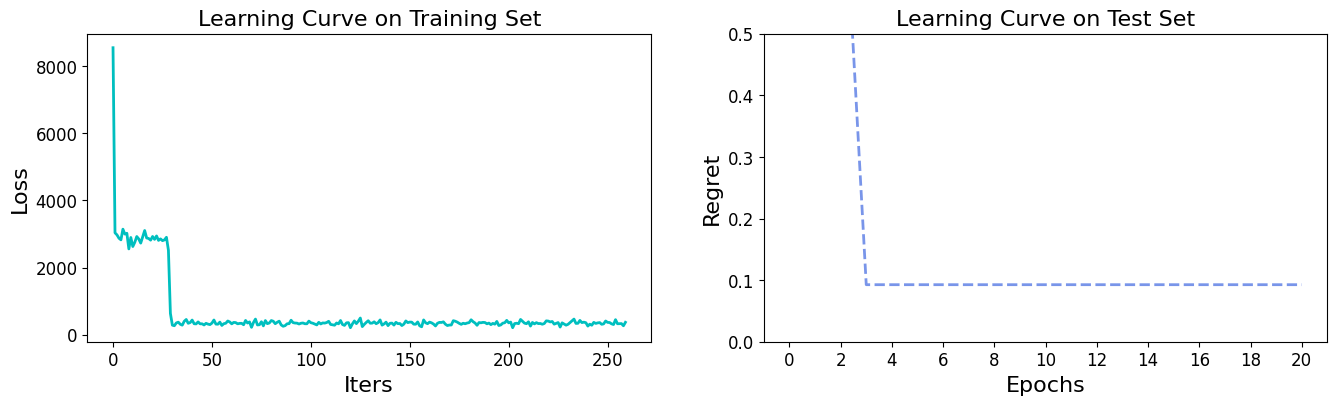


Running experiment with simple_regression and nid

Starting experiment - Model: simple_regression, Method: nid
Epoch  10, Loss:  327.4286, Regret:  9.2584%
Epoch  20, Loss:  476.0000, Regret:  9.2584%
Total Elapsed Time: 1600.49 Sec.


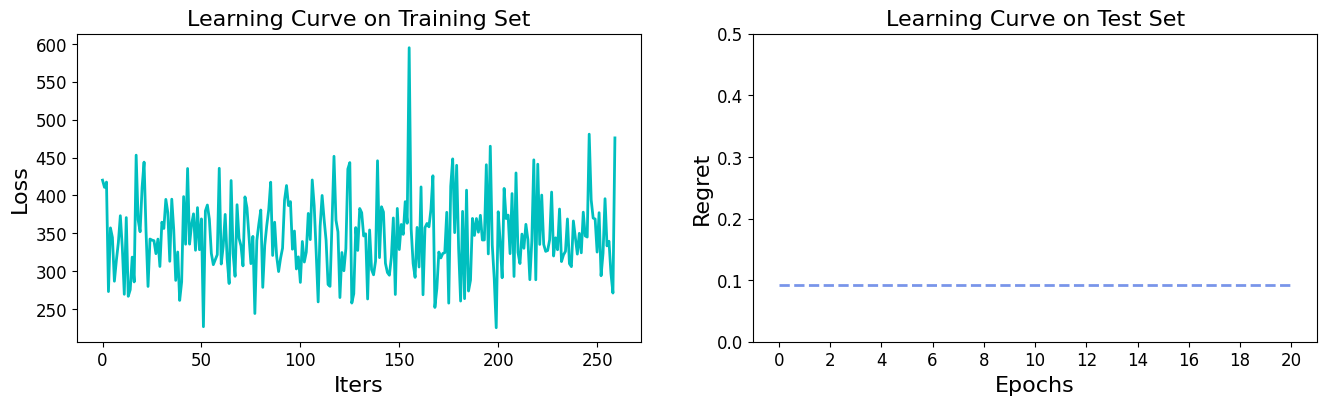


Running experiment with mlp and dbb

Starting experiment - Model: mlp, Method: dbb
Epoch  10, Loss: 1509.0714, Regret: 49.2604%
Epoch  20, Loss: 1588.9286, Regret: 49.2604%
Total Elapsed Time: 2710.68 Sec.


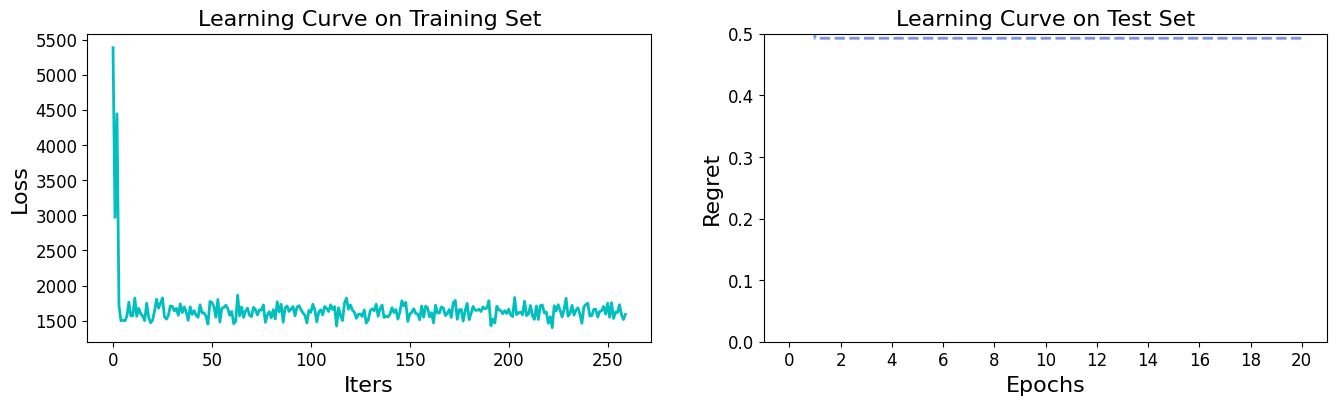


Running experiment with mlp and nid

Starting experiment - Model: mlp, Method: nid
Epoch  10, Loss:  380.0714, Regret: 12.2329%
Epoch  20, Loss:  418.2857, Regret: 12.2329%
Total Elapsed Time: 1611.40 Sec.


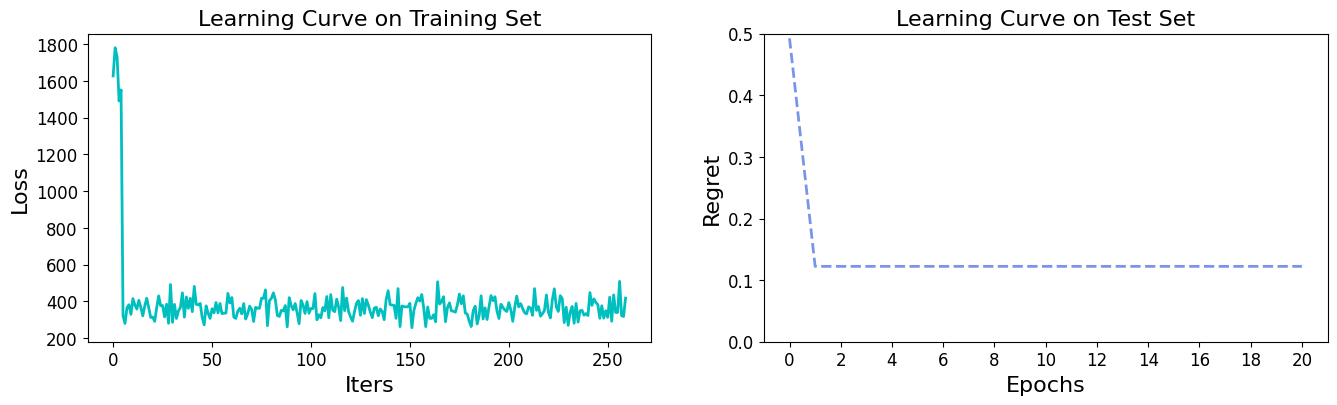


Experiments completed. Results saved in: experiments_20251121_202908


In [ ]:
results, experiment_dirs = run_pipeline(
    x_train, x_test, c_train, c_test, optmodel, n_aircraft
)
print(f"\nExperiments completed. Results saved in: {experiment_dirs['base']}")

In [ ]:
from scipy.optimize import OptimizeResult

def get_flat_params(model): #flattens parmams
    with torch.no_grad():
        vec = torch.nn.utils.parameters_to_vector(model.parameters()).cpu().numpy()
    return vec

def set_flat_params(model, theta_flat): #inverse of above, takes flattened params and writes it back into the model
    with torch.no_grad():
        t = torch.tensor(theta_flat, dtype=torch.float32)
        torch.nn.utils.vector_to_parameters(t, model.parameters())

def regret_objective(theta_flat, model, optmodel, loader): #using the param vector, computes a scalar regret value over the dataset
    model.cpu()
    set_flat_params(model, theta_flat)
    model.eval()
    with torch.no_grad():
        r = pyepo.metric.regret(model, optmodel, loader)
    return float(r)

def run_pso(model, optmodel, loader_train,
            num_particles=10, max_iters=30,
            w=0.7, c1=1.5, c2=1.5, verbose=True):
    theta0 = get_flat_params(model)
    dim = theta0.shape[0]

    positions = np.array([theta0 + 0.1 * np.random.randn(dim) for _ in range(num_particles)])
    #Start each particle around the initial model params theta0 with small Gaussian noise and velocities.
    velocities = 0.1 * np.random.randn(num_particles, dim)

    pbest_pos = positions.copy()
    pbest_val = np.full(num_particles, np.inf, dtype=float)

    gbest_pos = None
    gbest_val = np.inf
    gbest_history = []

    # pbest_*: each particle’s personal best position and regret.
    # gbest_*: global best across all particles.
    # gbest_history: record best regret per iteration.

    start_time = time.time()

    # For each particle:
    # Evaluate regret at its current position using regret_objective.
    # Update personal best if this is better.
    # Update global best if this is best overall.
    # Then updates velocities and positions

    for it in range(max_iters):
        for i in range(num_particles):

            regret = regret_objective(positions[i], model, optmodel, loader_train)

            if regret < pbest_val[i]:
                pbest_val[i] = regret
                pbest_pos[i] = positions[i].copy()

            if regret < gbest_val:
                gbest_val = regret
                gbest_pos = positions[i].copy()

        gbest_history.append(gbest_val)

        # Classic PSO formula:
        # w: inertia (keeps moving same direction)
        # c1: cognitive (move toward personal best)
        # c2: social (move toward global best)
        # r1, r2: random factors in [0,1].

        for i in range(num_particles):
            r1 = np.random.rand(dim)
            r2 = np.random.rand(dim)
            velocities[i] = (
                w * velocities[i]
                + c1 * r1 * (pbest_pos[i] - positions[i])
                + c2 * r2 * (gbest_pos - positions[i])
            )
            positions[i] += velocities[i]

        if verbose:
            print(f"PSO iter {it+1}/{max_iters}, best train regret: {gbest_val:.4f}")

    elapsed = time.time() - start_time
    set_flat_params(model, gbest_pos)

    res = OptimizeResult()
    res.x = gbest_pos
    res.fun = gbest_val
    res.nit = max_iters
    res.history = gbest_history
    res.elapsed = elapsed
    return res


In [ ]:
dataset_train = optDataset(optmodel, x_train, c_train)
dataset_test  = optDataset(optmodel, x_test,  c_test)

loader_train = DataLoader(dataset_train, batch_size=32, shuffle=False)
loader_test  = DataLoader(dataset_test,  batch_size=32, shuffle=False)


Optimizing for optDataset...


100%|██████████| 398/398 [00:04<00:00, 86.23it/s]

Optimizing for optDataset...



100%|██████████| 100/100 [00:01<00:00, 87.12it/s]


In [ ]:
input_size = x_train.shape[-1]
output_size = c_train.shape[-1]

# ----- PSO for SimpleRegression -----
pso_simple = SimpleRegression(input_size, output_size)  # fresh model (CPU)
res_simple = run_pso(
    model=pso_simple,
    optmodel=optmodel,
    loader_train=loader_train,
    num_particles=10,
    max_iters=10
)

pso_simple.eval()
with torch.no_grad():
    simple_pso_test_regret = pyepo.metric.regret(pso_simple, optmodel, loader_test)

# Create a result dict in the same style as DFL methods:
simple_pso_result = {
    'model_name': 'simple_regression',
    'method_name': 'pso',
    'loss_log': [float(x) for x in res_simple.history],
    'loss_log_regret': [float(x) for x in res_simple.history],
    'elapsed_time': float(res_simple.elapsed),
    'final_regret': float(simple_pso_test_regret),
    'hyperparameters': {
        'num_particles': 10,
        'max_iters': 10,
        'w': 0.7,
        'c1': 1.5,
        'c2': 1.5,
    }
}

# Attach to existing results:
results.setdefault('simple_regression', {})
results['simple_regression']['pso'] = simple_pso_result


# ----- PSO for MLP (optional) -----
pso_mlp = MLP(input_size, 64, output_size)
res_mlp = run_pso(
    model=pso_mlp,
    optmodel=optmodel,
    loader_train=loader_train,
    num_particles=10,
    max_iters=10
)

pso_mlp.eval()
with torch.no_grad():
    mlp_pso_test_regret = pyepo.metric.regret(pso_mlp, optmodel, loader_test)

mlp_pso_result = {
    'model_name': 'mlp',
    'method_name': 'pso',
    'loss_log': [float(x) for x in res_mlp.history],
    'loss_log_regret': [float(x) for x in res_mlp.history],
    'elapsed_time': float(res_mlp.elapsed),
    'final_regret': float(mlp_pso_test_regret),
    'hyperparameters': {
        'num_particles': 10,
        'max_iters': 10,
        'w': 0.7,
        'c1': 1.5,
        'c2': 1.5,
    }
}

results.setdefault('mlp', {})
results['mlp']['pso'] = mlp_pso_result

PSO iter 1/10, best train regret: 1.1318
PSO iter 2/10, best train regret: 0.5880
PSO iter 3/10, best train regret: 0.4821
PSO iter 4/10, best train regret: 0.4821
PSO iter 5/10, best train regret: 0.3595
PSO iter 6/10, best train regret: 0.1222
PSO iter 7/10, best train regret: 0.1203
PSO iter 8/10, best train regret: 0.1085
PSO iter 9/10, best train regret: 0.1085
PSO iter 10/10, best train regret: 0.1077
PSO iter 1/10, best train regret: 1.2397
PSO iter 2/10, best train regret: 0.9355
PSO iter 3/10, best train regret: 0.9355
PSO iter 4/10, best train regret: 0.9289
PSO iter 5/10, best train regret: 0.7929
PSO iter 6/10, best train regret: 0.7225
PSO iter 7/10, best train regret: 0.4376
PSO iter 8/10, best train regret: 0.4376
PSO iter 9/10, best train regret: 0.4376
PSO iter 10/10, best train regret: 0.1287


In [ ]:
for model_name, methods in results.items():
    print(f"\nModel: {model_name}")
    for method_name, res in methods.items():
        print(f"  {method_name:5s}  final_regret = {res['final_regret']:.4f},  elapsed = {res['elapsed_time']:.1f} s")


Model: simple_regression
  dbb    final_regret = 0.0926,  elapsed = 2817.7 s
  nid    final_regret = 0.0926,  elapsed = 1600.5 s
  pso    final_regret = 0.1223,  elapsed = 169.5 s

Model: mlp
  dbb    final_regret = 0.4926,  elapsed = 2710.7 s
  nid    final_regret = 0.1223,  elapsed = 1611.4 s
  pso    final_regret = 0.1118,  elapsed = 171.0 s
